Author: Imran Feisal

Date: 28/12/2024

Description:

This notebook demonstrates a complete end-to-end workflow for the VITAI project:
1. Load & preprocess Synthea data (including any existing composite health index),
2. Compute the Charlson Comorbidity Index (CCI) within the notebook,
3. (Optional) Train or load existing models (VAE/TabNet) for additional representation learning,
4. Perform clustering to create a cluster-based health index,
5. Visualize & validate results (2D, 3D, plus comparison with demographic factors),
6. Compare new cluster-based index with Charlson Comorbidity Index or any existing health index
   to observe correlation & differences.

In [1]:
# %%capture
# !pip install seaborn plotly scikit-learn umap-learn  # If needed

In [2]:
import sys
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import (silhouette_score, calinski_harabasz_score,
                             davies_bouldin_score)
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
from scipy.stats import f_oneway, kruskal, shapiro, levene

# For 3D plotting with matplotlib
from mpl_toolkits.mplot3d import Axes3D

# Assuming we run this notebook from the 'project' directory
project_dir = os.path.abspath("..")
data_dir = os.path.join(project_dir, "Data")
sys.path.append(project_dir)

from data_preprocessing import main as preprocess_main
from health_index import main as health_main
from charlson_comorbidity import load_cci_mapping, compute_cci
from vae_model import main as vae_main
from tabnet_model import main as tabnet_main

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [3]:
print(data_dir)

c:\Users\imran\Documents\VITAI\Data


### 1. Preprocess and Health Index if not done

In [4]:
if not os.path.exists(os.path.join(data_dir, 'patient_data_sequences.pkl')):
    print("patient_data_sequences.pkl not found. Running data_preprocessing.py...")
    preprocess_main()

if not os.path.exists(os.path.join(data_dir, 'patient_data_with_health_index.pkl')):
    print("patient_data_with_health_index.pkl not found. Running health_index.py...")
    health_main()

print("Data pre-processing and health index generation step complete.")

Data pre-processing and health index generation step complete.


### 2. Compute CCI

In [5]:
# Load conditions for CCI calculation
conditions_path = os.path.join(data_dir, 'conditions.csv')
if not os.path.exists(conditions_path):
    raise FileNotFoundError("conditions.csv not found. Cannot compute CCI.")

conditions = pd.read_csv(conditions_path, usecols=['PATIENT', 'CODE', 'DESCRIPTION'])

# Load CCI mapping
cci_mapping = load_cci_mapping(data_dir)  # res195-comorbidity-cci-snomed.csv

# Compute CCI
patient_cci = compute_cci(conditions, cci_mapping)

# Merge CCI into the existing patient data with the health index
patient_data_path = os.path.join(data_dir, 'patient_data_with_health_index.pkl')
patient_data = pd.read_pickle(patient_data_path)

# Merge on patient ID
patient_data = patient_data.merge(
    patient_cci, how='left',
    left_on='Id', right_on='PATIENT'
)
patient_data.drop(columns='PATIENT', inplace=True)
patient_data['CharlsonIndex'] = patient_data['CharlsonIndex'].fillna(0)

# Save the new file that includes the CCI
cci_output_path = os.path.join(data_dir, 'patient_data_with_health_index_cci.pkl')
patient_data.to_pickle(cci_output_path)

print("Charlson Comorbidity Index merged. Saved to:", cci_output_path)
patient_data.head()

Charlson Comorbidity Index merged. Saved to: c:\Users\imran\Documents\VITAI\Data\patient_data_with_health_index_cci.pkl


,Id,MARITAL,RACE,ETHNICITY,GENDER,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,INCOME,AGE,DECEASED,AGE_AT_DEATH,SEQUENCE,Comorbidity_Score,Hospitalizations_Count,Medications_Count,Abnormal_Observations_Count,Health_Index,CharlsonIndex
0,2237e2d6-4755-bef8-d3d5-c718f8a0d98e,Unknown,white,nonhispanic,F,4681.49,142.36,167799,1.152635,0,1.152635,"[[0, 738, 1152, 1153, 1154, 1155, 1156, 1157, ...",6.0,0.0,1.0,3,1.014717,0.0
1,6865616f-0f82-ca17-f133-e14a9d220ee4,Unknown,white,nonhispanic,F,17768.36,0.00,36182,9.341547,0,9.341547,"[[0, 1152, 1153, 1154, 1155, 1156, 1157, 1158,...",10.0,0.0,1.0,24,1.066265,0.0
2,4a425864-327f-9bce-8ee4-9a2dc7498eb5,Unknown,black,nonhispanic,M,10064.69,5326.86,143562,10.009582,0,10.009582,"[[0, 738, 1152, 1153, 1154, 1155, 1156, 1157, ...",9.0,0.0,0.0,36,1.088778,0.0
3,1f370f41-c89b-e5ea-80b4-16462d29f73d,Unknown,white,nonhispanic,M,34082.86,10990.01,40518,16.235455,0,16.235455,"[[0], [1152, 1153, 1154, 1178, 1179, 1158, 115...",14.0,0.0,3.0,19,1.066220,0.0
4,6f117f2d-2916-9866-258c-bf26cff3aefc,Unknown,white,hispanic,F,2816.47,43878.80,9458,16.005476,0,16.005476,"[[0], [1, 748, 1174], [1, 1174], [738, 1152, 1...",15.0,0.0,2.0,7,1.039107,0.0


### 3. Train Models with CCI - just pass the parameter to main
We simply call the main functions from the existing scripts, passing the new input file.

This should incorporate the CCI into the final data used by the models.


In [6]:
# 3.1 Train the VAE model
print("---- Training VAE model with CCI data ----")
vae_main(input_file='patient_data_with_health_index_cci.pkl')

# 3.2 Train the TabNet model
print("---- Training TabNet model with CCI data ----")
tabnet_main(input_file='patient_data_with_health_index_cci.pkl')

print("Model training complete.")

---- Training VAE model with CCI data ----


INFO:vae_model:Data prepared for VAE.
INFO:vae_model:VAE model built.


Epoch 1/100
733/733 [==============================] - ETA: 0s - loss: 0.2521WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


733/733 [==============================] - 4s 4ms/step - loss: 0.2521 - val_loss: 0.2212
Epoch 2/100
720/733 [============================>.] - ETA: 0s - loss: 0.2139WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


733/733 [==============================] - 3s 4ms/step - loss: 0.2139 - val_loss: 0.2154
Epoch 3/100
728/733 [============================>.] - ETA: 0s - loss: 0.2092WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


733/733 [==============================] - 3s 4ms/step - loss: 0.2092 - val_loss: 0.2104
Epoch 4/100
729/733 [============================>.] - ETA: 0s - loss: 0.2077WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


733/733 [==============================] - 3s 4ms/step - loss: 0.2077 - val_loss: 0.2097
Epoch 5/100
732/733 [============================>.] - ETA: 0s - loss: 0.2064WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


733/733 [==============================] - 3s 4ms/step - loss: 0.2064 - val_loss: 0.2086
Epoch 6/100
733/733 [==============================] - ETA: 0s - loss: 0.2055WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


733/733 [==============================] - 3s 4ms/step - loss: 0.2055 - val_loss: 0.2065
Epoch 7/100
733/733 [==============================] - 3s 4ms/step - loss: 0.2049 - val_loss: 0.2075
Epoch 8/100
731/733 [============================>.] - ETA: 0s - loss: 0.2041WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


733/733 [==============================] - 3s 4ms/step - loss: 0.2041 - val_loss: 0.2065
Epoch 9/100
729/733 [============================>.] - ETA: 0s - loss: 0.2039WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


733/733 [==============================] - 3s 4ms/step - loss: 0.2039 - val_loss: 0.2061
Epoch 10/100
733/733 [==============================] - ETA: 0s - loss: 0.2034WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


733/733 [==============================] - 3s 4ms/step - loss: 0.2034 - val_loss: 0.2061
Epoch 11/100
731/733 [============================>.] - ETA: 0s - loss: 0.2033WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


733/733 [==============================] - 3s 4ms/step - loss: 0.2033 - val_loss: 0.2053
Epoch 12/100
733/733 [==============================] - 3s 4ms/step - loss: 0.2028 - val_loss: 0.2054
Epoch 13/100
733/733 [==============================] - 3s 4ms/step - loss: 0.2025 - val_loss: 0.2061
Epoch 14/100
721/733 [============================>.] - ETA: 0s - loss: 0.2025WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


733/733 [==============================] - 3s 4ms/step - loss: 0.2025 - val_loss: 0.2041
Epoch 15/100
733/733 [==============================] - 3s 4ms/step - loss: 0.2022 - val_loss: 0.2057
Epoch 16/100
733/733 [==============================] - 3s 4ms/step - loss: 0.2021 - val_loss: 0.2046
Epoch 17/100
733/733 [==============================] - 3s 4ms/step - loss: 0.2023 - val_loss: 0.2046
Epoch 18/100
726/733 [============================>.] - ETA: 0s - loss: 0.2016WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


733/733 [==============================] - 3s 4ms/step - loss: 0.2016 - val_loss: 0.2038
Epoch 19/100
733/733 [==============================] - 3s 4ms/step - loss: 0.2016 - val_loss: 0.2039
Epoch 20/100
728/733 [============================>.] - ETA: 0s - loss: 0.2017WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


733/733 [==============================] - 3s 4ms/step - loss: 0.2017 - val_loss: 0.2031
Epoch 21/100
733/733 [==============================] - 3s 4ms/step - loss: 0.2016 - val_loss: 0.2037
Epoch 22/100
733/733 [==============================] - 3s 4ms/step - loss: 0.2015 - val_loss: 0.2035
Epoch 23/100
733/733 [==============================] - 3s 4ms/step - loss: 0.2013 - val_loss: 0.2041
Epoch 24/100
733/733 [==============================] - 3s 4ms/step - loss: 0.2016 - val_loss: 0.2036
Epoch 25/100
733/733 [==============================] - 3s 4ms/step - loss: 0.2012 - val_loss: 0.2040
Epoch 26/100
733/733 [==============================] - 3s 4ms/step - loss: 0.2012 - val_loss: 0.2042
Epoch 27/100
733/733 [==============================] - 3s 5ms/step - loss: 0.2015 - val_loss: 0.2036
Epoch 28/100
733/733 [==============================] - 3s 5ms/step - loss: 0.2010 - val_loss: 0.2035
Epoch 29/100
732/733 [============================>.] - ETA: 0s - loss: 0.2012WARNING:tensorflo

733/733 [==============================] - 3s 5ms/step - loss: 0.2012 - val_loss: 0.2027
Epoch 30/100
733/733 [==============================] - 3s 5ms/step - loss: 0.2009 - val_loss: 0.2030
Epoch 31/100
733/733 [==============================] - 4s 5ms/step - loss: 0.2008 - val_loss: 0.2031
Epoch 32/100
733/733 [==============================] - 4s 5ms/step - loss: 0.2010 - val_loss: 0.2032
Epoch 33/100
733/733 [==============================] - 3s 4ms/step - loss: 0.2007 - val_loss: 0.2038
Epoch 34/100
733/733 [==============================] - 3s 4ms/step - loss: 0.2009 - val_loss: 0.2031
Epoch 35/100
733/733 [==============================] - 3s 5ms/step - loss: 0.2008 - val_loss: 0.2037
Epoch 36/100
733/733 [==============================] - 3s 5ms/step - loss: 0.2006 - val_loss: 0.2031
Epoch 37/100
733/733 [==============================] - 3s 4ms/step - loss: 0.2007 - val_loss: 0.2029
Epoch 38/100
733/733 [==============================] - 3s 5ms/step - loss: 0.2006 - val_loss: 

733/733 [==============================] - 4s 5ms/step - loss: 0.2007 - val_loss: 0.2026
Epoch 40/100
728/733 [============================>.] - ETA: 0s - loss: 0.2005WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


733/733 [==============================] - 4s 5ms/step - loss: 0.2005 - val_loss: 0.2024
Epoch 41/100
733/733 [==============================] - 4s 5ms/step - loss: 0.2008 - val_loss: 0.2033
Epoch 42/100
733/733 [==============================] - 3s 5ms/step - loss: 0.2007 - val_loss: 0.2037
Epoch 43/100
733/733 [==============================] - 3s 5ms/step - loss: 0.2005 - val_loss: 0.2033
Epoch 44/100
733/733 [==============================] - 3s 5ms/step - loss: 0.2002 - val_loss: 0.2027
Epoch 45/100
732/733 [============================>.] - ETA: 0s - loss: 0.2003WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


733/733 [==============================] - 3s 5ms/step - loss: 0.2003 - val_loss: 0.2023
Epoch 46/100
733/733 [==============================] - 4s 5ms/step - loss: 0.2004 - val_loss: 0.2028
Epoch 47/100
722/733 [============================>.] - ETA: 0s - loss: 0.2005WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


733/733 [==============================] - 3s 5ms/step - loss: 0.2004 - val_loss: 0.2023
Epoch 48/100
733/733 [==============================] - 4s 5ms/step - loss: 0.2003 - val_loss: 0.2032
Epoch 49/100
732/733 [============================>.] - ETA: 0s - loss: 0.2002WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


733/733 [==============================] - 4s 5ms/step - loss: 0.2002 - val_loss: 0.2018
Epoch 50/100
733/733 [==============================] - 4s 5ms/step - loss: 0.2000 - val_loss: 0.2038
Epoch 51/100
733/733 [==============================] - 4s 5ms/step - loss: 0.2004 - val_loss: 0.2030
Epoch 52/100
733/733 [==============================] - 4s 5ms/step - loss: 0.2003 - val_loss: 0.2035
Epoch 53/100
733/733 [==============================] - 4s 5ms/step - loss: 0.2004 - val_loss: 0.2025
Epoch 54/100
733/733 [==============================] - 4s 5ms/step - loss: 0.1999 - val_loss: 0.2021
Epoch 55/100
733/733 [==============================] - 3s 5ms/step - loss: 0.2001 - val_loss: 0.2021
Epoch 56/100
733/733 [==============================] - 4s 5ms/step - loss: 0.2001 - val_loss: 0.2022
Epoch 57/100
723/733 [============================>.] - ETA: 0s - loss: 0.2002WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being share

733/733 [==============================] - 4s 5ms/step - loss: 0.2002 - val_loss: 0.2017
Epoch 58/100
733/733 [==============================] - 4s 5ms/step - loss: 0.1998 - val_loss: 0.2028
Epoch 59/100
733/733 [==============================] - 4s 5ms/step - loss: 0.2001 - val_loss: 0.2028
Epoch 60/100
733/733 [==============================] - 4s 5ms/step - loss: 0.2002 - val_loss: 0.2028
Epoch 61/100
733/733 [==============================] - 4s 5ms/step - loss: 0.2001 - val_loss: 0.2027
Epoch 62/100
733/733 [==============================] - 4s 5ms/step - loss: 0.1999 - val_loss: 0.2018
Epoch 63/100
728/733 [============================>.] - ETA: 0s - loss: 0.1998WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


733/733 [==============================] - 4s 5ms/step - loss: 0.1998 - val_loss: 0.2017
Epoch 64/100
733/733 [==============================] - 4s 5ms/step - loss: 0.1998 - val_loss: 0.2033
Epoch 65/100
733/733 [==============================] - 4s 5ms/step - loss: 0.1999 - val_loss: 0.2025
Epoch 66/100
733/733 [==============================] - 4s 5ms/step - loss: 0.1995 - val_loss: 0.2018
Epoch 67/100
724/733 [============================>.] - ETA: 0s - loss: 0.1998WARNING:tensorflow:Found duplicated `Variable`s in Model's `weights`. This is usually caused by `Variable`s being shared by Layers in the Model. These `Variable`s will be treated as separate `Variable`s when the Model is restored. To avoid this, please save with `save_format="tf"`.


733/733 [==============================] - 4s 5ms/step - loss: 0.1997 - val_loss: 0.2013
Epoch 68/100
733/733 [==============================] - 4s 5ms/step - loss: 0.1998 - val_loss: 0.2024
Epoch 69/100
733/733 [==============================] - 4s 5ms/step - loss: 0.1995 - val_loss: 0.2028
Epoch 70/100
733/733 [==============================] - 4s 5ms/step - loss: 0.2001 - val_loss: 0.2021
Epoch 71/100
733/733 [==============================] - 4s 5ms/step - loss: 0.1999 - val_loss: 0.2026
Epoch 72/100
733/733 [==============================] - 4s 5ms/step - loss: 0.1999 - val_loss: 0.2022
Epoch 73/100
733/733 [==============================] - 4s 5ms/step - loss: 0.1998 - val_loss: 0.2020
Epoch 74/100
733/733 [==============================] - 4s 5ms/step - loss: 0.1997 - val_loss: 0.2025
Epoch 75/100
733/733 [==============================] - 4s 5ms/step - loss: 0.1995 - val_loss: 0.2027
Epoch 76/100
733/733 [==============================] - 4s 5ms/step - loss: 0.1995 - val_loss: 

INFO:tensorflow:Assets written to: vae_model\assets


INFO:tensorflow:Assets written to: vae_model\assets
INFO:vae_model:VAE trained and saved.


INFO:tensorflow:Assets written to: vae_encoder\assets


INFO:tensorflow:Assets written to: vae_encoder\assets


INFO:tensorflow:Assets written to: vae_decoder\assets


INFO:tensorflow:Assets written to: vae_decoder\assets


7327/7327 [==============================] - 5s 655us/step


INFO:vae_model:Latent features saved.


---- Training TabNet model with CCI data ----


INFO:tabnet_model:Patient data loaded.
INFO:tabnet_model:Data prepared for TabNet.
[I 2024-12-28 15:01:22,705] A new study created in memory with name: no-name-d103bcad-df1a-420e-93d2-d36f76ff9744



Early stopping occurred at epoch 44 with best_epoch = 34 and best_val_0_rmse = 0.76811


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 46 and best_val_0_rmse = 0.62674


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_0_rmse = 0.7763


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-28 15:11:42,731] Trial 0 finished with value: 0.5284801272519991 and parameters: {'n_d': 60, 'n_a': 27, 'n_steps': 8, 'gamma': 1.7201298827601679, 'lambda_sparse': 0.00022602152668979757, 'lr': 0.00010308890369480842, 'cat_emb_dim': 5, 'n_shared': 4, 'n_independent': 2}. Best is trial 0 with value: 0.5284801272519991.


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_rmse = 0.25829


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 41 and best_val_0_rmse = 0.18227


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_rmse = 0.21155


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-28 15:21:01,520] Trial 1 finished with value: 0.04823014766946593 and parameters: {'n_d': 59, 'n_a': 48, 'n_steps': 9, 'gamma': 1.932259714853415, 'lambda_sparse': 3.795376778769241e-06, 'lr': 0.0007574999130034891, 'cat_emb_dim': 1, 'n_shared': 2, 'n_independent': 2}. Best is trial 1 with value: 0.04823014766946593.


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_0_rmse = 0.44314


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_rmse = 0.45997


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_rmse = 0.4972


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-28 15:32:26,530] Trial 2 finished with value: 0.21838448410276054 and parameters: {'n_d': 60, 'n_a': 18, 'n_steps': 8, 'gamma': 1.5244326349836719, 'lambda_sparse': 8.748997464355663e-06, 'lr': 0.00028601004325513115, 'cat_emb_dim': 3, 'n_shared': 2, 'n_independent': 5}. Best is trial 1 with value: 0.04823014766946593.


Stop training because you reached max_epochs = 50 with best_epoch = 46 and best_val_0_rmse = 0.27788


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_0_rmse = 0.22528


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_0_rmse = 0.25783


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-28 15:44:10,145] Trial 3 finished with value: 0.06481560776739566 and parameters: {'n_d': 43, 'n_a': 56, 'n_steps': 8, 'gamma': 1.863110961879178, 'lambda_sparse': 1.146646796634615e-05, 'lr': 0.0005624872213598819, 'cat_emb_dim': 2, 'n_shared': 3, 'n_independent': 5}. Best is trial 1 with value: 0.04823014766946593.


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_0_rmse = 0.06313


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 44 and best_val_0_rmse = 0.06401


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 47 with best_epoch = 37 and best_val_0_rmse = 0.07393


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-28 15:52:59,319] Trial 4 finished with value: 0.004516436259788052 and parameters: {'n_d': 31, 'n_a': 64, 'n_steps': 8, 'gamma': 1.2194677984301747, 'lambda_sparse': 4.839082134538091e-06, 'lr': 0.00520197690245362, 'cat_emb_dim': 4, 'n_shared': 2, 'n_independent': 2}. Best is trial 4 with value: 0.004516436259788052.



Early stopping occurred at epoch 47 with best_epoch = 37 and best_val_0_rmse = 0.10903


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 45 and best_val_0_rmse = 0.12721


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_0_rmse = 0.09509


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-28 16:01:50,010] Trial 5 finished with value: 0.012370536874589028 and parameters: {'n_d': 57, 'n_a': 43, 'n_steps': 5, 'gamma': 1.6700697821928792, 'lambda_sparse': 0.0009942876069158773, 'lr': 0.0010892221381648263, 'cat_emb_dim': 4, 'n_shared': 5, 'n_independent': 3}. Best is trial 4 with value: 0.004516436259788052.


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_rmse = 0.0548


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 44 and best_val_0_rmse = 0.05618


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_0_rmse = 0.05776


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-28 16:09:05,719] Trial 6 finished with value: 0.0031649022367099045 and parameters: {'n_d': 48, 'n_a': 40, 'n_steps': 7, 'gamma': 1.1340882028433485, 'lambda_sparse': 3.6307021157354092e-06, 'lr': 0.004997085550768716, 'cat_emb_dim': 3, 'n_shared': 2, 'n_independent': 2}. Best is trial 6 with value: 0.0031649022367099045.


Stop training because you reached max_epochs = 50 with best_epoch = 46 and best_val_0_rmse = 0.68473


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 46 and best_val_0_rmse = 0.70659


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_rmse = 0.62694


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-28 16:18:09,197] Trial 7 finished with value: 0.45372874791007495 and parameters: {'n_d': 59, 'n_a': 60, 'n_steps': 8, 'gamma': 1.250673164332548, 'lambda_sparse': 0.00048114042858418525, 'lr': 0.00010427297173836834, 'cat_emb_dim': 1, 'n_shared': 4, 'n_independent': 1}. Best is trial 6 with value: 0.0031649022367099045.


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_0_rmse = 0.385


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_0_rmse = 0.3433


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_0_rmse = 0.32692


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-28 16:27:28,766] Trial 8 finished with value: 0.12432003380997192 and parameters: {'n_d': 48, 'n_a': 50, 'n_steps': 4, 'gamma': 1.4389880584515318, 'lambda_sparse': 0.0009347271534043953, 'lr': 0.0002133233945957629, 'cat_emb_dim': 2, 'n_shared': 4, 'n_independent': 5}. Best is trial 6 with value: 0.0031649022367099045.


Stop training because you reached max_epochs = 50 with best_epoch = 43 and best_val_0_rmse = 0.04107


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_rmse = 0.05186


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 47 with best_epoch = 37 and best_val_0_rmse = 0.0377


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-28 16:32:50,286] Trial 9 finished with value: 0.0019324471869420418 and parameters: {'n_d': 11, 'n_a': 12, 'n_steps': 3, 'gamma': 1.79034920007061, 'lambda_sparse': 3.572585429052522e-06, 'lr': 0.007056576244070833, 'cat_emb_dim': 4, 'n_shared': 3, 'n_independent': 2}. Best is trial 9 with value: 0.0019324471869420418.


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_0_rmse = 0.04882


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_0_rmse = 0.05166


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_0_rmse = 0.07051


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-28 16:38:51,744] Trial 10 finished with value: 0.003341449206954295 and parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 3, 'gamma': 1.7486137932056838, 'lambda_sparse': 1.0777294791115989e-06, 'lr': 0.0019898342955395228, 'cat_emb_dim': 5, 'n_shared': 1, 'n_independent': 4}. Best is trial 9 with value: 0.0019324471869420418.



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_rmse = 0.0559


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 32 with best_epoch = 22 and best_val_0_rmse = 0.04878


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 42 and best_val_0_rmse = 0.04435


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-28 16:44:53,933] Trial 11 finished with value: 0.002490510297733318 and parameters: {'n_d': 24, 'n_a': 34, 'n_steps': 6, 'gamma': 1.0949117491875542, 'lambda_sparse': 4.590540008651419e-05, 'lr': 0.008751321381566314, 'cat_emb_dim': 3, 'n_shared': 3, 'n_independent': 1}. Best is trial 9 with value: 0.0019324471869420418.


Stop training because you reached max_epochs = 50 with best_epoch = 47 and best_val_0_rmse = 0.03156


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 41 and best_val_0_rmse = 0.03584


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 41 with best_epoch = 31 and best_val_0_rmse = 0.04001


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-28 16:51:40,222] Trial 12 finished with value: 0.0012936517114057716 and parameters: {'n_d': 16, 'n_a': 30, 'n_steps': 6, 'gamma': 1.0090613083856224, 'lambda_sparse': 6.208534955434638e-05, 'lr': 0.009056356636397013, 'cat_emb_dim': 4, 'n_shared': 3, 'n_independent': 1}. Best is trial 12 with value: 0.0012936517114057716.



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_rmse = 0.03764


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_rmse = 0.03177


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_rmse = 0.04474


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-28 16:55:34,193] Trial 13 finished with value: 0.0014760459451232423 and parameters: {'n_d': 9, 'n_a': 19, 'n_steps': 3, 'gamma': 1.4022730871913218, 'lambda_sparse': 6.145148050339013e-05, 'lr': 0.009810400643147588, 'cat_emb_dim': 4, 'n_shared': 3, 'n_independent': 1}. Best is trial 12 with value: 0.0012936517114057716.



Early stopping occurred at epoch 45 with best_epoch = 35 and best_val_0_rmse = 0.07931


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_rmse = 0.08109


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 43 and best_val_0_rmse = 0.07346


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-28 17:10:49,786] Trial 14 finished with value: 0.0060872119873945875 and parameters: {'n_d': 18, 'n_a': 26, 'n_steps': 5, 'gamma': 1.3793671282889057, 'lambda_sparse': 7.518518869500513e-05, 'lr': 0.0026100883776399124, 'cat_emb_dim': 4, 'n_shared': 5, 'n_independent': 1}. Best is trial 12 with value: 0.0012936517114057716.


Stop training because you reached max_epochs = 50 with best_epoch = 45 and best_val_0_rmse = 0.06061


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 42 and best_val_0_rmse = 0.06711


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_rmse = 0.05588


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-28 17:31:47,507] Trial 15 finished with value: 0.0037669648023585596 and parameters: {'n_d': 17, 'n_a': 22, 'n_steps': 10, 'gamma': 1.0063821499230978, 'lambda_sparse': 8.379035295992567e-05, 'lr': 0.002994692639608338, 'cat_emb_dim': 5, 'n_shared': 1, 'n_independent': 3}. Best is trial 12 with value: 0.0012936517114057716.



Early stopping occurred at epoch 22 with best_epoch = 12 and best_val_0_rmse = 0.08061


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_rmse = 0.08554


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 38 with best_epoch = 28 and best_val_0_rmse = 0.05359


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-28 17:40:58,465] Trial 16 finished with value: 0.005562486900130355 and parameters: {'n_d': 29, 'n_a': 32, 'n_steps': 5, 'gamma': 1.568887906162971, 'lambda_sparse': 2.396030332631608e-05, 'lr': 0.00886849194736101, 'cat_emb_dim': 4, 'n_shared': 4, 'n_independent': 1}. Best is trial 12 with value: 0.0012936517114057716.



Early stopping occurred at epoch 49 with best_epoch = 39 and best_val_0_rmse = 0.0654


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 32 with best_epoch = 22 and best_val_0_rmse = 0.06529


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 36 with best_epoch = 26 and best_val_0_rmse = 0.07138


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-28 17:56:37,568] Trial 17 finished with value: 0.004545143866433068 and parameters: {'n_d': 16, 'n_a': 14, 'n_steps': 6, 'gamma': 1.3118304131445837, 'lambda_sparse': 0.000187718618075151, 'lr': 0.0036939834694632834, 'cat_emb_dim': 2, 'n_shared': 3, 'n_independent': 4}. Best is trial 12 with value: 0.0012936517114057716.


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_rmse = 0.11059


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 42 and best_val_0_rmse = 0.10488


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_rmse = 0.07489


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-28 18:12:27,215] Trial 18 finished with value: 0.009613198933867246 and parameters: {'n_d': 23, 'n_a': 29, 'n_steps': 4, 'gamma': 1.00403869904555, 'lambda_sparse': 2.7170544262950964e-05, 'lr': 0.0012747174933634734, 'cat_emb_dim': 3, 'n_shared': 4, 'n_independent': 3}. Best is trial 12 with value: 0.0012936517114057716.


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_0_rmse = 0.07063


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_0_rmse = 0.0706


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 48 and best_val_0_rmse = 0.05105


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-28 18:23:19,366] Trial 19 finished with value: 0.004193372801699184 and parameters: {'n_d': 36, 'n_a': 18, 'n_steps': 4, 'gamma': 1.6085672214838507, 'lambda_sparse': 0.00016354758578700324, 'lr': 0.0017405449871550878, 'cat_emb_dim': 5, 'n_shared': 2, 'n_independent': 1}. Best is trial 12 with value: 0.0012936517114057716.
INFO:tabnet_model:Best trial: {'n_d': 16, 'n_a': 30, 'n_steps': 6, 'gamma': 1.0090613083856224, 'lambda_sparse': 6.208534955434638e-05, 'lr': 0.009056356636397013, 'cat_emb_dim': 4, 'n_shared': 3, 'n_independent': 1}
c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.95789 | val_0_rmse: 0.5395  |  0:00:01s
epoch 1  | loss: 0.13313 | val_0_rmse: 0.25717 |  0:00:03s
epoch 2  | loss: 0.04453 | val_0_rmse: 0.21206 |  0:00:05s
epoch 3  | loss: 0.02855 | val_0_rmse: 0.18359 |  0:00:06s
epoch 4  | loss: 0.02046 | val_0_rmse: 0.13791 |  0:00:08s
epoch 5  | loss: 0.01743 | val_0_rmse: 0.12153 |  0:00:10s
epoch 6  | loss: 0.01296 | val_0_rmse: 0.10694 |  0:00:11s
epoch 7  | loss: 0.01353 | val_0_rmse: 0.11076 |  0:00:13s
epoch 8  | loss: 0.01297 | val_0_rmse: 0.13266 |  0:00:15s
epoch 9  | loss: 0.01497 | val_0_rmse: 0.09148 |  0:00:16s
epoch 10 | loss: 0.00881 | val_0_rmse: 0.07008 |  0:00:18s
epoch 11 | loss: 0.00566 | val_0_rmse: 0.06958 |  0:00:19s
epoch 12 | loss: 0.00543 | val_0_rmse: 0.07067 |  0:00:21s
epoch 13 | loss: 0.00553 | val_0_rmse: 0.06338 |  0:00:23s
epoch 14 | loss: 0.00497 | val_0_rmse: 0.0984  |  0:00:25s
epoch 15 | loss: 0.00544 | val_0_rmse: 0.10692 |  0:00:26s
epoch 16 | loss: 0.0047  | val_0_rmse: 0.04759 |  0:00:2

c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
INFO:tabnet_model:TabNet model trained and saved.
INFO:tabnet_model:Test MSE: 0.0011
INFO:tabnet_model:Test R2: 0.9960


Successfully saved model at tabnet_model.zip
Model training complete.


### 4. Analysis: Clustering & Visualization

In [7]:
# 4.1 Load Outputs: Latent Features (from VAE) and TabNet Predictions
#     (We assume the scripts save them as CSV for further analysis.)
latent_features_path = 'latent_features_vae.csv'
tabnet_predictions_path = 'tabnet_predictions.csv'

if not (os.path.exists(latent_features_path) and os.path.exists(tabnet_predictions_path)):
    raise FileNotFoundError("latent_features_vae.csv or tabnet_predictions.csv not found. "
                            "Please ensure the VAE/TabNet scripts saved them correctly.")

latent_features = pd.read_csv(latent_features_path)
tabnet_predictions = pd.read_csv(tabnet_predictions_path)

print("Loaded latent_features:", latent_features.shape)
print("Loaded tabnet_predictions:", tabnet_predictions.shape)

# Merge on 'Id' to get a single DataFrame with VAE latent + TabNet predictions
data_merged = latent_features.merge(tabnet_predictions, on='Id', how='inner')

print("Merged data shape:", data_merged.shape)
data_merged.head()

Loaded latent_features: (234458, 21)
Loaded tabnet_predictions: (23446, 2)
Merged data shape: (23446, 22)


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,Id,Predicted_Health_Index
0,-0.001318,0.006353,-0.685191,0.006830,-0.009508,-0.013478,0.023620,-0.000376,-0.010951,0.110780,...,0.013992,0.373590,0.016517,0.013492,0.004275,0.005210,-0.008621,-0.321083,cf21e568-b54d-b143-154c-555047e2b1fd,1.808733
1,0.003185,0.003455,0.469998,-0.005232,-0.000450,-0.003434,0.007667,-0.007429,0.000013,-0.029965,...,0.002115,0.288963,0.000884,0.002812,-0.008964,-0.006559,-0.006506,0.000569,4203cca8-a9d2-3435-fee6-a80a35e20a1a,1.073411
2,0.011770,-0.003685,-0.366012,0.006704,-0.010835,-0.009029,0.021247,-0.004270,0.007584,0.068732,...,0.000630,1.238305,-0.000505,0.026617,-0.011075,-0.004517,0.002546,0.251168,361ec0a9-2ac3-c168-7343-c24117ba816d,1.202395
3,-0.017618,0.009366,-0.201278,-0.014454,0.019822,-0.014772,-0.007644,-0.003709,-0.008939,-0.296347,...,0.007766,-0.958188,-0.006492,-0.003394,0.015921,-0.012436,0.005901,0.104513,d8591cc3-911b-4c87-8a87-213c1464149a,1.044319
4,-0.011603,0.008751,-0.310408,0.030883,-0.011273,0.001269,0.006630,0.011099,0.020408,1.938835,...,0.003394,0.771862,-0.004771,0.017907,-0.008877,0.017353,0.031733,0.285863,d28f0db9-74a6-7e49-7631-372881de8b67,1.156480


In [8]:
########################################################
# 4.2 Clustering on the Combined Latent + Predictions
########################################################

# Here we do the clustering on the combined feature space:
# - VAE latent dimensions
# - Possibly "Predicted_Health_Index" from TabNet
# You can include more columns if you'd like.

X_columns = [col for col in data_merged.columns
             if col not in ('Id', 'Predicted_Health_Index')]
# Example, we will cluster on VAE latent features only:
# X_columns = [col for col in data_merged.columns if col.startswith('0') or col.startswith('1')...]

X = data_merged[X_columns].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

cluster_range = range(6, 10)  

# Compare multiple methods
sil_kmeans, sil_agg, best_eps = [], [], None

########################
# K-Means
########################
kmeans_scores = []
for n in cluster_range:
    km = KMeans(n_clusters=n, random_state=42)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    ch = calinski_harabasz_score(X_scaled, labels)
    db = davies_bouldin_score(X_scaled, labels)
    kmeans_scores.append((n, sil, ch, db))
    
kmeans_df = pd.DataFrame(kmeans_scores, columns=['k','silhouette','calinski','davies_bouldin'])
kmeans_df['method'] = 'KMeans'
kmeans_df

# Choose best k for KMeans by a combination approach
kmeans_df['sil_rank'] = kmeans_df['silhouette'].rank(ascending=False)
kmeans_df['ch_rank'] = kmeans_df['calinski'].rank(ascending=False)
kmeans_df['db_rank'] = kmeans_df['davies_bouldin'].rank(ascending=True)
kmeans_df['avg_rank'] = kmeans_df[['sil_rank','ch_rank','db_rank']].mean(axis=1)
best_k = kmeans_df.loc[kmeans_df['avg_rank'].idxmin(), 'k']

print("=== KMeans Results ===")
display(kmeans_df)
print(f"Chosen K for KMeans = {best_k:.0f} based on ranking.")

# Final K-Means
kmeans_final = KMeans(n_clusters=int(best_k), random_state=42)
kmeans_labels = kmeans_final.fit_predict(X_scaled)

############################
# Agglomerative Clustering
############################
agg_scores = []
for n in cluster_range:
    agg = AgglomerativeClustering(n_clusters=n)
    labels = agg.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    ch = calinski_harabasz_score(X_scaled, labels)
    db = davies_bouldin_score(X_scaled, labels)
    agg_scores.append((n, sil, ch, db))
agg_df = pd.DataFrame(agg_scores, columns=['k','silhouette','calinski','davies_bouldin'])
agg_df['method'] = 'Agglomerative'

agg_df['sil_rank'] = agg_df['silhouette'].rank(ascending=False)
agg_df['ch_rank'] = agg_df['calinski'].rank(ascending=False)
agg_df['db_rank'] = agg_df['davies_bouldin'].rank(ascending=True)
agg_df['avg_rank'] = agg_df[['sil_rank','ch_rank','db_rank']].mean(axis=1)

best_k_agg = agg_df.loc[agg_df['avg_rank'].idxmin(), 'k']
agg_final = AgglomerativeClustering(n_clusters=int(best_k_agg))
agg_labels = agg_final.fit_predict(X_scaled)

print("=== Agglomerative Results ===")
display(agg_df)
print(f"Chosen K for Agglomerative = {best_k_agg:.0f} based on ranking.")

########################
# DBSCAN (Adaptive Eps)
########################
from sklearn.neighbors import NearestNeighbors
neighbors = 5
nbrs = NearestNeighbors(n_neighbors=neighbors).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
distances = np.sort(distances[:, neighbors - 1], axis=0)
# For example, pick 90% point as epsilon
epsilon = distances[int(0.9 * len(distances))]

dbscan = DBSCAN(eps=epsilon, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

def cluster_scores(X_data, labels):
    # If only 1 cluster or everything is noise => skip
    unique_lbls = set(labels)
    if len(unique_lbls) < 2:
        return (np.nan, np.nan, np.nan)
    sil = silhouette_score(X_data, labels)
    ch = calinski_harabasz_score(X_data, labels)
    db = davies_bouldin_score(X_data, labels)
    return sil, ch, db

sil_db, ch_db, db_db = cluster_scores(X_scaled, dbscan_labels)
print(f"\n=== DBSCAN results (automatic eps={epsilon:.3f}): ===")
print(f"  Silhouette = {sil_db:.4f}, CH = {ch_db:.1f}, DB = {db_db:.4f}")


=== KMeans Results ===


,k,silhouette,calinski,davies_bouldin,method,sil_rank,ch_rank,db_rank,avg_rank
0,6,0.286157,4718.051958,1.259352,KMeans,4.0,2.0,2.0,2.666667
1,7,0.307800,4721.445863,1.248716,KMeans,2.0,1.0,1.0,1.333333
2,8,0.302976,4460.223358,1.290176,KMeans,3.0,4.0,4.0,3.666667
3,9,0.316498,4554.768934,1.283563,KMeans,1.0,3.0,3.0,2.333333


Chosen K for KMeans = 7 based on ranking.
=== Agglomerative Results ===


,k,silhouette,calinski,davies_bouldin,method,sil_rank,ch_rank,db_rank,avg_rank
0,6,0.334159,4192.607807,1.404716,Agglomerative,1.0,2.0,4.0,2.333333
1,7,0.292799,4178.256425,1.377826,Agglomerative,4.0,3.0,2.0,3.000000
2,8,0.305717,4283.019091,1.380888,Agglomerative,3.0,1.0,3.0,2.333333
3,9,0.307857,4157.734546,1.263452,Agglomerative,2.0,4.0,1.0,2.333333


Chosen K for Agglomerative = 6 based on ranking.

=== DBSCAN results (automatic eps=1.553): ===
  Silhouette = 0.0969, CH = 108.7, DB = 1.6457


In [9]:
##################################################
# 4.3 Pick best method + create final cluster idx
##################################################

# Combine into a single DataFrame for comparison
all_eval = pd.concat([kmeans_df[['method','k','silhouette','calinski','davies_bouldin','avg_rank']],
                      agg_df[['method','k','silhouette','calinski','davies_bouldin','avg_rank']]], 
                     ignore_index=True)

# DBSCAN is not "k-based", so let's just add it as well (k=NaN):
all_eval = pd.concat([all_eval, pd.DataFrame({
    'method':['DBSCAN'],
    'k':[np.nan],
    'silhouette':[sil_db],
    'calinski':[ch_db],
    'davies_bouldin':[db_db],
    'avg_rank':[np.nan]
})], ignore_index=True)

display(all_eval)

# Decide best method based on minimal 'avg_rank' among K-Means / Agg + maybe DBSCAN
method_options = all_eval.dropna(subset=['avg_rank'])
best_method_idx = method_options['avg_rank'].idxmin()
best_method = method_options.loc[best_method_idx, 'method']

if best_method == 'KMeans':
    final_labels = kmeans_labels
    chosen_k = best_k
elif best_method == 'Agglomerative':
    final_labels = agg_labels
    chosen_k = best_k_agg
else:
    # If DBSCAN was better by some separate logic, pick that
    # or you can compare the silhouette or other metrics manually
    final_labels = dbscan_labels
    chosen_k = -1

data_merged['Cluster'] = final_labels

print(f"\nFinal method chosen: {best_method}, with k={chosen_k} (if applicable).")


,method,k,silhouette,calinski,davies_bouldin,avg_rank
0,KMeans,6.0,0.286157,4718.051958,1.259352,2.666667
1,KMeans,7.0,0.307800,4721.445863,1.248716,1.333333
2,KMeans,8.0,0.302976,4460.223358,1.290176,3.666667
3,KMeans,9.0,0.316498,4554.768934,1.283563,2.333333
4,Agglomerative,6.0,0.334159,4192.607807,1.404716,2.333333
5,Agglomerative,7.0,0.292799,4178.256425,1.377826,3.000000
6,Agglomerative,8.0,0.305717,4283.019091,1.380888,2.333333
7,Agglomerative,9.0,0.307857,4157.734546,1.263452,2.333333
8,DBSCAN,NaN,0.096947,108.686301,1.645709,NaN



Final method chosen: KMeans, with k=7 (if applicable).


In [10]:
##################################################
# 4.4 Create a "Severity Index" from Clusters
##################################################
# For demonstration, we map clusters to severity levels
# by ordering them by the mean 'Predicted_Health_Index'.

cluster_map = (
    data_merged
    .groupby('Cluster')['Predicted_Health_Index']
    .mean()
    .sort_values()
    .reset_index()
)
cluster_map['Severity_Index'] = range(1, len(cluster_map) + 1)  # 1..#clusters
mapping = cluster_map.set_index('Cluster')['Severity_Index'].to_dict()
data_merged['Severity_Index'] = data_merged['Cluster'].map(mapping)

print("Mapped clusters to severity levels (1 = least severe, higher = more severe).")
cluster_map


Mapped clusters to severity levels (1 = least severe, higher = more severe).


,Cluster,Predicted_Health_Index,Severity_Index
0,4,1.268581,1
1,2,1.272401,2
2,1,1.275112,3
3,0,1.278380,4
4,3,1.289914,5
5,6,1.294453,6
6,5,1.301498,7


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


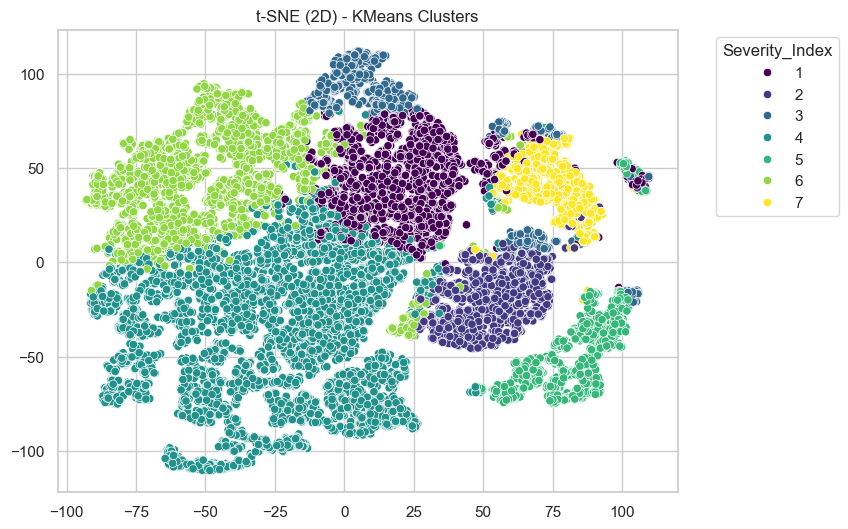

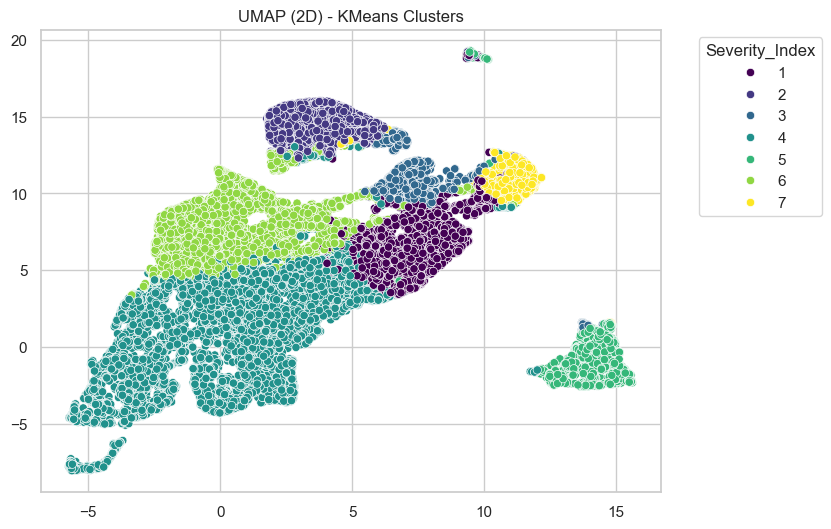

In [11]:
##################################
# 4.5 2D t-SNE and UMAP Plots
##################################
tsne_2d = TSNE(n_components=2, random_state=42)
tsne_results = tsne_2d.fit_transform(X_scaled)

umap_2d = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_2d.fit_transform(X_scaled)

# Plot t-SNE
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=tsne_results[:,0], 
    y=tsne_results[:,1],
    hue=data_merged['Severity_Index'],
    palette='viridis'
)
plt.title(f"t-SNE (2D) - {best_method} Clusters")
plt.legend(title='Severity_Index', bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()

# Plot UMAP
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=umap_results[:,0],
    y=umap_results[:,1],
    hue=data_merged['Severity_Index'],
    palette='viridis'
)
plt.title(f"UMAP (2D) - {best_method} Clusters")
plt.legend(title='Severity_Index', bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


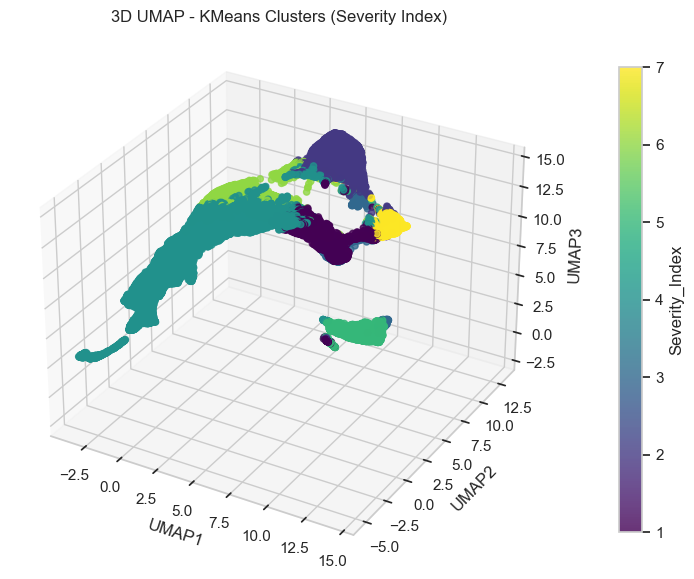

In [12]:
####################################
# 4.6 3D Visualization (UMAP or t-SNE)
####################################

# Let's do 3D with UMAP for demonstration:
umap_3d = umap.UMAP(n_components=3, random_state=42)
umap_3d_results = umap_3d.fit_transform(X_scaled)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    umap_3d_results[:,0],
    umap_3d_results[:,1],
    umap_3d_results[:,2],
    c=data_merged['Severity_Index'],
    cmap='viridis',
    alpha=0.8
)

ax.set_title(f"3D UMAP - {best_method} Clusters (Severity Index)")
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
ax.set_zlabel("UMAP3")
cbar = plt.colorbar(sc, ax=ax, fraction=0.03, pad=0.09)
cbar.set_label("Severity_Index")

plt.show()


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
C:\Users\imran\AppData\Local\Temp\ipykernel_41468\4199804959.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Severity_Index', y='CharlsonIndex', data=final_data, palette='viridis')
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


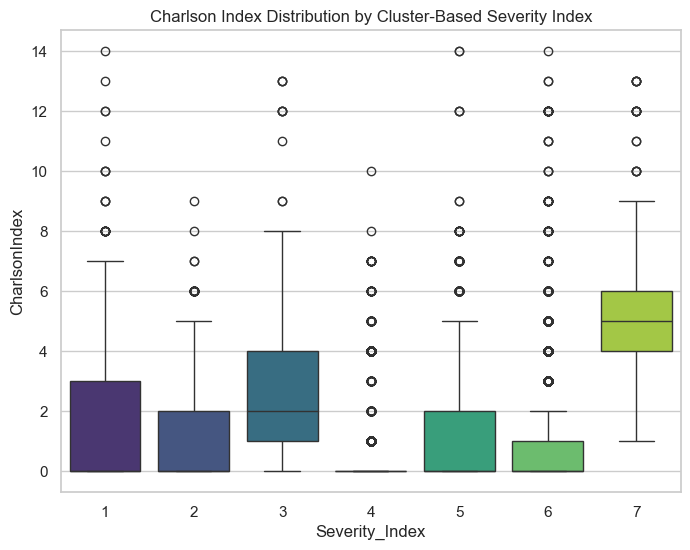

Correlation between cluster-based severity and CharlsonIndex: 0.094


In [13]:
########################################
# 4.7 Compare with Charlson Comorbidity
########################################

# Re-load the patient data with CCI if needed, or if you have it in the same DF:
if 'CharlsonIndex' not in patient_data.columns:
    print("Reloading patient_data_with_health_index_cci to get CharlsonIndex...")

patient_data_cci = pd.read_pickle(cci_output_path)
# Merge with 'data_merged' by the 'Id' (some rows might have been lost if shapes differ)
final_data = data_merged.merge(patient_data_cci[['Id','CharlsonIndex','RACE','ETHNICITY','MARITAL','GENDER']],
                               on='Id', how='left')

# Now we can do some plots
plt.figure(figsize=(8,6))
sns.boxplot(x='Severity_Index', y='CharlsonIndex', data=final_data, palette='viridis')
plt.title("Charlson Index Distribution by Cluster-Based Severity Index")
plt.show()

corr_val = final_data['Severity_Index'].corr(final_data['CharlsonIndex'])
print(f"Correlation between cluster-based severity and CharlsonIndex: {corr_val:.3f}")


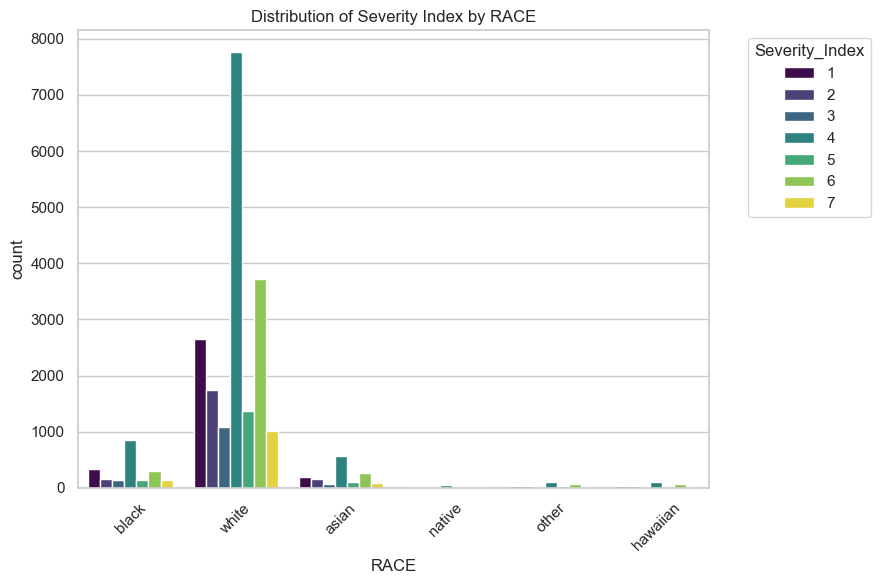

C:\Users\imran\AppData\Local\Temp\ipykernel_41468\2550531882.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=factor, y='Severity_Index', data=final_data, palette='viridis')


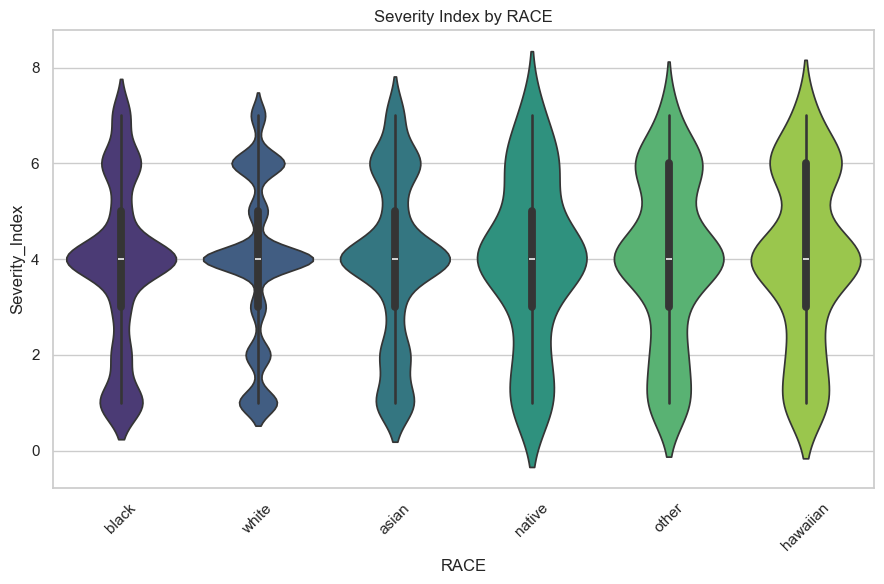

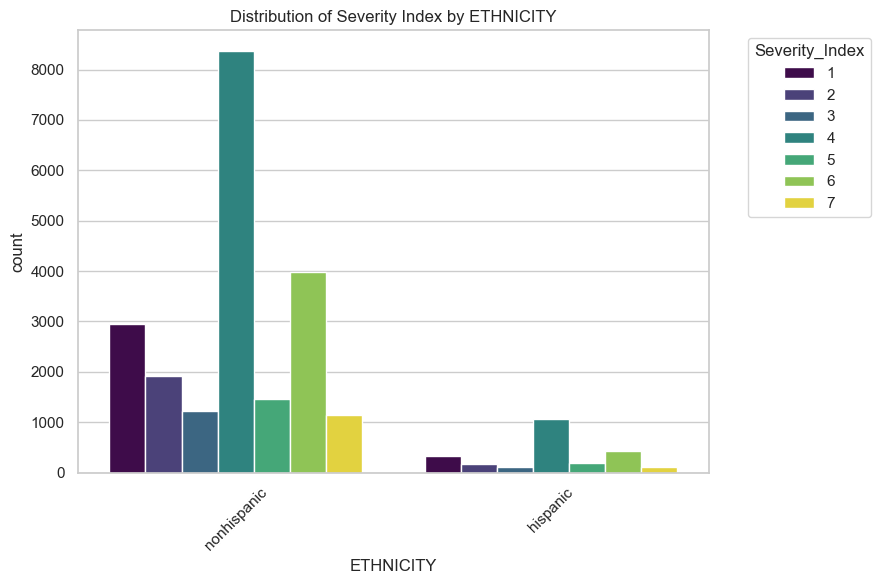

C:\Users\imran\AppData\Local\Temp\ipykernel_41468\2550531882.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=factor, y='Severity_Index', data=final_data, palette='viridis')


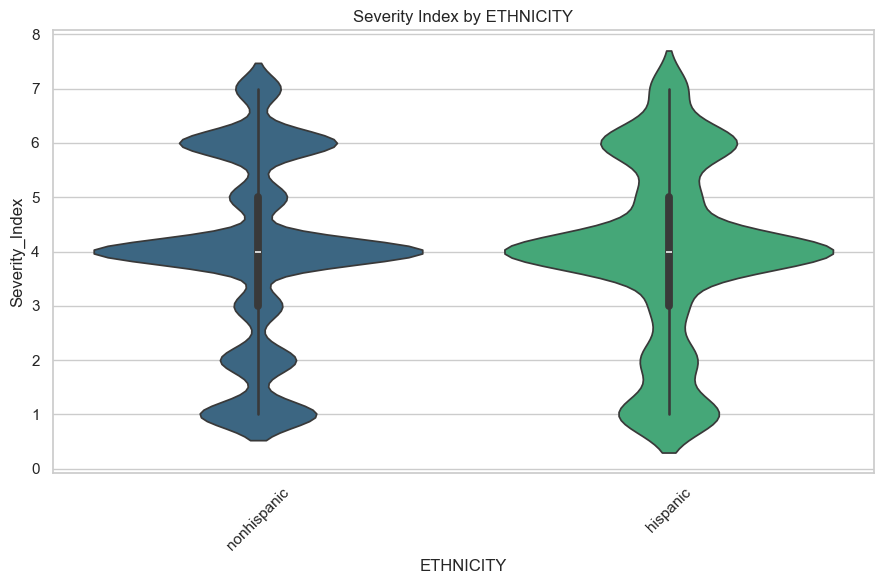

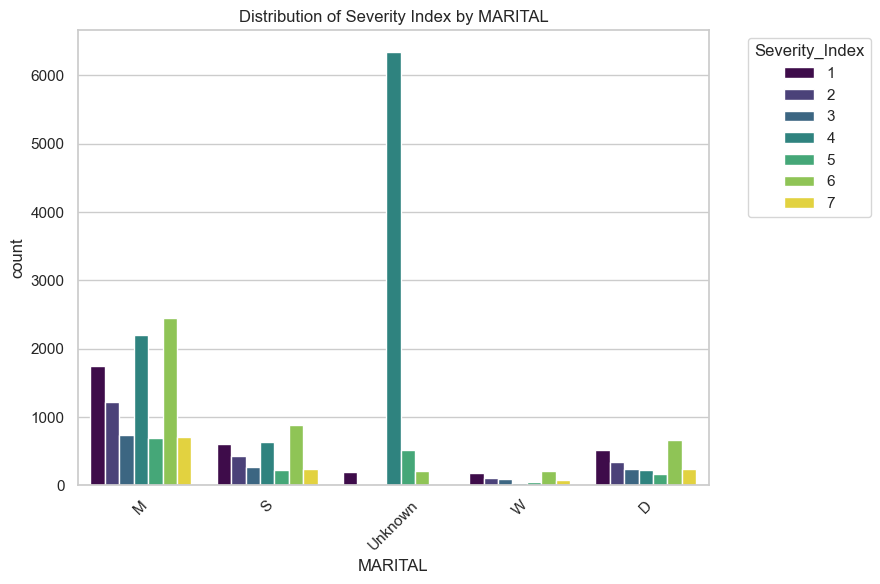

C:\Users\imran\AppData\Local\Temp\ipykernel_41468\2550531882.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=factor, y='Severity_Index', data=final_data, palette='viridis')


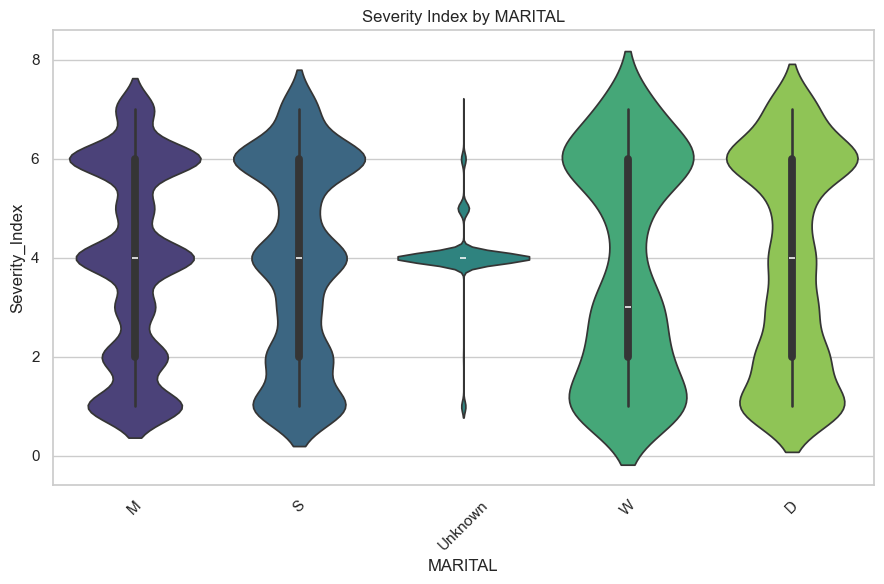

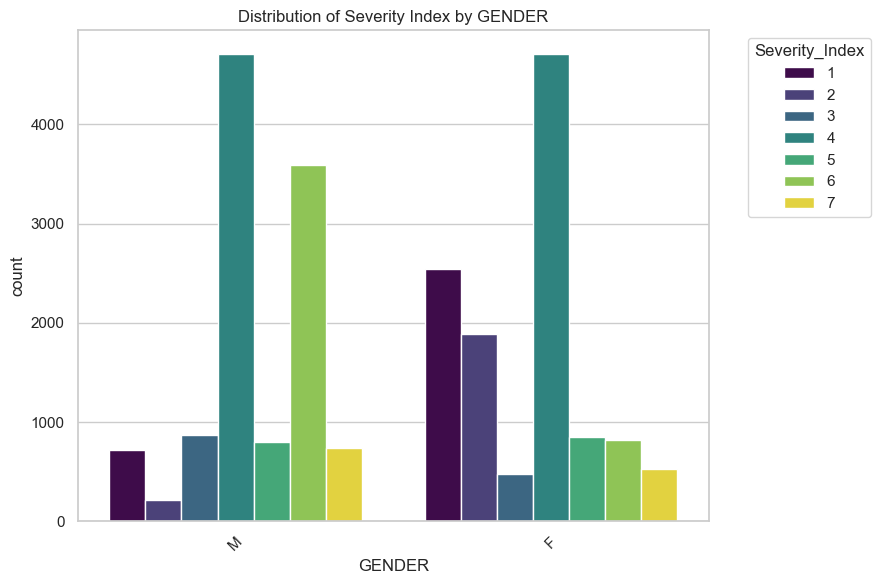

C:\Users\imran\AppData\Local\Temp\ipykernel_41468\2550531882.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=factor, y='Severity_Index', data=final_data, palette='viridis')


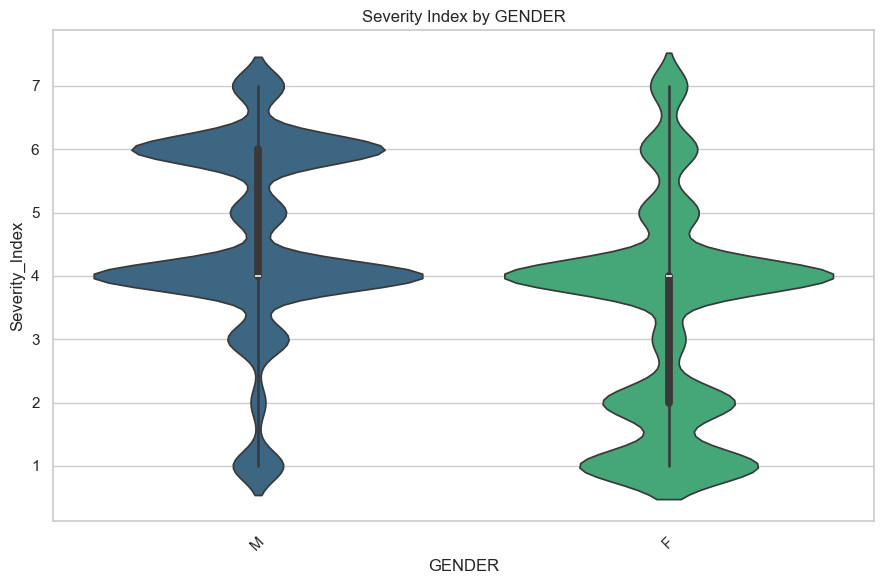

In [14]:
###################################################
# 4.8 Preliminary Health Inequalities Examination
###################################################
# Let's see how "Severity_Index" differs by Race/Ethnicity/Marital/Gender

demo_factors = ['RACE','ETHNICITY','MARITAL','GENDER']
for factor in demo_factors:
    if factor in final_data.columns:
        plt.figure(figsize=(9,6))
        sns.countplot(x=factor, hue='Severity_Index', data=final_data, palette='viridis')
        plt.title(f"Distribution of Severity Index by {factor}")
        plt.xticks(rotation=45)
        plt.legend(title='Severity_Index', bbox_to_anchor=(1.05,1), loc='upper left')
        plt.tight_layout()
        plt.show()

        # Another approach: violin plot or boxplot
        plt.figure(figsize=(9,6))
        sns.violinplot(x=factor, y='Severity_Index', data=final_data, palette='viridis')
        plt.title(f"Severity Index by {factor}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


In [15]:
############################################################
# 4.9 ANOVA / Kruskal / Normality Tests across Clusters
############################################################

clusters = final_data['Cluster'].unique()
normality_pvals = []
for c in clusters:
    grp = final_data.loc[final_data['Cluster'] == c, 'Predicted_Health_Index']
    stat, p = shapiro(grp)
    normality_pvals.append(p)

if any(p < 0.05 for p in normality_pvals):
    # Use Kruskal-Wallis
    groups = [final_data.loc[final_data['Cluster'] == c, 'Predicted_Health_Index'] for c in clusters]
    kw_stat, kw_p = kruskal(*groups)
    print(f"Kruskal-Wallis: H={kw_stat:.4f}, p={kw_p:.4g}")
else:
    # Check variance homogeneity
    groups = [final_data.loc[final_data['Cluster'] == c, 'Predicted_Health_Index'] for c in clusters]
    lv_stat, lv_p = levene(*groups)
    if lv_p < 0.05:
        # Non-homogeneous => Kruskal
        kw_stat, kw_p = kruskal(*groups)
        print(f"Kruskal-Wallis: H={kw_stat:.4f}, p={kw_p:.4g}")
    else:
        # ANOVA
        f_stat, f_p = f_oneway(*groups)
        print(f"ANOVA: F={f_stat:.4f}, p={f_p:.4g}")

print("Analysis complete. Full dataset with CCI integrated.")


Kruskal-Wallis: H=2.9643, p=0.8133
Analysis complete. Full dataset with CCI integrated.


c:\Users\imran\miniconda3\envs\tf_gpu_env\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9420.
  res = hypotest_fun_out(*samples, **kwds)
